In [1]:
import cv2
import os

import matplotlib.pyplot as plt
import numpy as np

In [2]:
cascade_path = os.path.join(cv2.data.haarcascades, 'haarcascade_frontalface_default.xml')

face_cascade = cv2.CascadeClassifier(cascade_path)

In [3]:
def detect_and_draw_faces(bgr_image):
    
    image_with_rects = bgr_image.copy()
    
    gray_image = cv2.cvtColor(bgr_image, cv2.COLOR_BGR2GRAY)
    
    faces = face_cascade.detectMultiScale(
        gray_image,
        scaleFactor=1.1,
        minNeighbors=5,
        minSize=(30, 30)
    )
    for (x, y, w, h) in faces:
        cv2.rectangle(image_with_rects, (x, y), (x + w, y + h), (0, 255, 0), 2)
        
    # print(f"Функция: Найдено {len(faces)} лиц(а).")
    
    return image_with_rects 

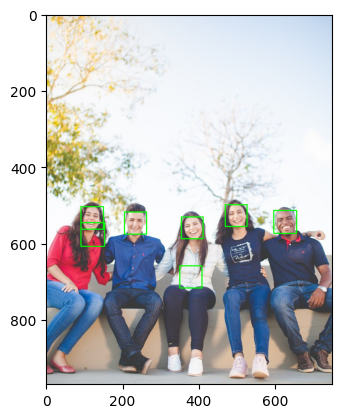

In [4]:
img_1 = cv2.imread('src/face/orig/photo_1.jpg')
img_1_res = detect_and_draw_faces(img_1)
plt.imshow(cv2.cvtColor(img_1_res, cv2.COLOR_BGR2RGB))

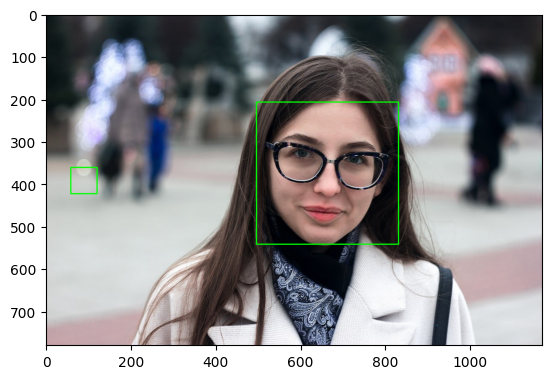

In [5]:
img_2 = cv2.imread('src/face/orig/photo_2.jpg')
img_2_res = detect_and_draw_faces(img_2)
plt.imshow(cv2.cvtColor(img_2_res, cv2.COLOR_BGR2RGB))

In [6]:
path_imgs = 'src/face/orig/'
out_path = 'src/face/results/'
all_photo = os.listdir(path_imgs)

for photo in all_photo:
    img = cv2.imread(path_imgs + photo)
    res = detect_and_draw_faces(img)
    cv2.imwrite(out_path + 'res_' + photo, res)

In [7]:
hog = cv2.HOGDescriptor()
hog.setSVMDetector(cv2.HOGDescriptor_getDefaultPeopleDetector())

In [14]:
def detect_people_hog(bgr_image, scale_factor=1.02, hit_threshold=0.0):
    (rects, weights) = hog.detectMultiScale(bgr_image, 
                                            winStride=(2, 2), 
                                            padding=(8, 8), 
                                            scale=scale_factor,
                                            hitThreshold=hit_threshold)
    
    rects = np.array([[x, y, x + w, y + h] for (x, y, w, h) in rects])
    
    final_rects, _ = cv2.groupRectangles(list(rects), 2, 0.2)
    
    image_output = bgr_image.copy()
    
    for (xA, yA, xB, yB) in final_rects:
        cv2.rectangle(image_output, (xA, yA), (xB, yB), (0, 255, 0), 2)
        
    # print(f"Обнаружено людей: {len(final_rects)}")
    
    # image_rgb = cv2.cvtColor(image_output, cv2.COLOR_BGR2RGB)
    
    return image_output

In [13]:
path_imgs = 'src/people/orig/'
out_path = 'src/people/results/'
all_photo = os.listdir(path_imgs)

for photo in all_photo:
    img = cv2.imread(os.path.join(path_imgs, photo))
    if img is None:
        print(f"⚠️ Пропущен файл '{photo}'. Не удалось загрузить.")
        continue
    res = detect_people_hog(img)
    cv2.imwrite(out_path + 'res_' + photo, res)

⚠️ Пропущен файл 'photo_15.jpg'. Не удалось загрузить.
⚠️ Пропущен файл 'photo_16.jpg'. Не удалось загрузить.


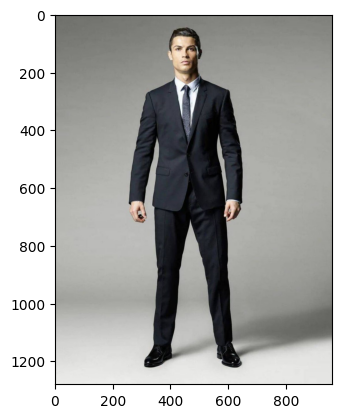

In [12]:
img_19 = cv2.imread('src/people/orig/photo_19.jpg')
img_19_res = detect_people_hog(img_19)
plt.imshow(cv2.cvtColor(img_19_res, cv2.COLOR_BGR2RGB))

In [17]:
from ultralytics import YOLO

Creating new Ultralytics Settings v0.0.6 file  
View Ultralytics Settings with 'yolo settings' or at 'C:\Users\masha\AppData\Roaming\Ultralytics\settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [18]:
yolo_model = YOLO('yolov8n.pt')

In [16]:
def detect_people_yolo(bgr_image):

    image_rgb = cv2.cvtColor(bgr_image, cv2.COLOR_BGR2RGB)
    
    results = yolo_model(image_rgb, classes=0, verbose=False)
    
    image_output = bgr_image.copy()
    
    if not results or not results[0].boxes:
        # print("YOLO: Люди не обнаружены.")
        return image_output
    
    detections = results[0].boxes.xyxy.cpu().numpy() # Получаем координаты (x1, y1, x2, y2)
    confidences = results[0].boxes.conf.cpu().numpy() # Получаем уверенность
    
    count = 0
    for box, conf in zip(detections, confidences):
        x1, y1, x2, y2 = map(int, box)
        
        if conf > 0.5: 
            cv2.rectangle(image_output, (x1, y1), (x2, y2), (0, 255, 0), 2)
            
            label = f"Person: {conf:.2f}"
            cv2.putText(image_output, label, (x1, y1 - 10), 
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
            count += 1
            
    # print(f"YOLO: Обнаружено {count} людей.")
    return image_output

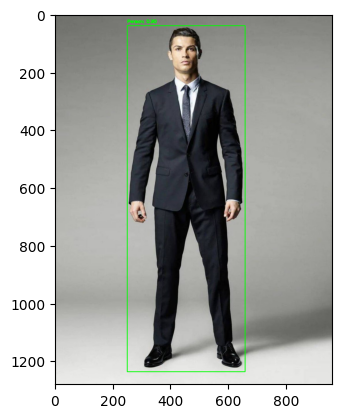

In [19]:
img_19 = cv2.imread('src/people/orig/photo_19.jpg')
img_19_res = detect_people_yolo(img_19)
plt.imshow(cv2.cvtColor(img_19_res, cv2.COLOR_BGR2RGB))

In [20]:
path_imgs = 'src/people/orig/'
out_path = 'src/people/res_yolo/'
all_photo = os.listdir(path_imgs)

for photo in all_photo:
    img = cv2.imread(os.path.join(path_imgs, photo))
    if img is None:
        print(f"⚠️ Пропущен файл '{photo}'. Не удалось загрузить.")
        continue
    res = detect_people_yolo(img)
    cv2.imwrite(out_path + 'res_' + photo, res)

⚠️ Пропущен файл 'photo_15.jpg'. Не удалось загрузить.
⚠️ Пропущен файл 'photo_16.jpg'. Не удалось загрузить.
